In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import shapiro, norm, probplot
import scipy.stats as stats
from statsmodels.stats.diagnostic import lilliefors
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn.preprocessing import PolynomialFeatures
from statsmodels.stats.diagnostic import linear_reset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from scipy import stats
import numpy as np

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline


In [2]:
# Загрузка данных
df = pd.read_csv('transformed_companies_cleaned.csv') 

In [3]:
pd.set_option('display.float_format', '{:.2f}'.format)

In [4]:
df = df.drop(columns=['representatives_count', 'branches_count'])

# 4.1 Анализ на наличие пропусков и выбросов

In [5]:
print("Информация о данных:")
print(f"Размер датасета: {df.shape}")
print(f"Количество строк: {df.shape[0]}")
print(f"Количество столбцов: {df.shape[1]}")


Информация о данных:
Размер датасета: (2917, 20)
Количество строк: 2917
Количество столбцов: 20


In [6]:
# Анализ пропусков
print("\nАнализ пропущенных значений:")
missing_data = df.isnull().sum()
missing_percent = (df.isnull().sum() / len(df)) * 100
missing_info = pd.DataFrame({
    'Количество пропусков': missing_data,
    'Процент пропусков': missing_percent
})
print(missing_info[missing_info['Количество пропусков'] > 0])


Анализ пропущенных значений:
                        Количество пропусков  Процент пропусков
company_name                              13               0.45
city                                     155               5.31
revenue                                  684              23.45
net_profit                               513              17.59
authorized_capital                       100               3.43
inn                                       66               2.26
contracts_count                         1660              56.91
customer_sum                            1660              56.91
supplier_sum                            1660              56.91
inspections_count                       1882              64.52
inspections_violations                  1882              64.52
inspections_knm                         1882              64.52
plaintiff_cases                         1548              53.07
defendant_cases                         1548              53.07
licenses_c

Заполнение пропусков

In [7]:
def fill_missing_values_by_group(df):
    # Создаем копию данных, чтобы не изменять исходный DataFrame
    df_filled = df.copy()
    
    # Создаем группы по выручке (если выручка доступна)
    if 'revenue' in df_filled.columns and df_filled['revenue'].notnull().sum() > 5:
        try:
            # Создаем 5 групп по выручке
            df_filled['revenue_group'] = pd.qcut(df_filled['revenue'], q=5, labels=False, duplicates='drop')
            print("Создано 5 групп по выручке")
        except:
            # Если не получается создать 5 групп (например, мало данных), создаем меньше групп
            df_filled['revenue_group'] = pd.qcut(df_filled['revenue'], q=3, labels=False, duplicates='drop')
            print("Создано 3 группы по выручке (недостаточно данных для 5 групп)")
    else:
        # Если выручка отсутствует или мало данных, создаем группы по уставному капиталу
        if 'authorized_capital' in df_filled.columns and df_filled['authorized_capital'].notnull().sum() > 5:
            try:
                df_filled['revenue_group'] = pd.qcut(df_filled['authorized_capital'], q=5, labels=False, duplicates='drop')
                print("Создано 5 групп по уставному капиталу (выручка недоступна)")
            except:
                df_filled['revenue_group'] = pd.qcut(df_filled['authorized_capital'], q=3, labels=False, duplicates='drop')
                print("Создано 3 группы по уставному капиталу (недостаточно данных для 5 групп)")
        else:
            # Если ни выручка, ни уставный капитал недоступны, создаем одну группу (все компании)
            df_filled['revenue_group'] = 0
            print("Все компании объединены в одну группу (недостаточно данных для сегментации)")

    # Определяем колонки для заполнения
    # Исключаем: company_id, company_name, city, registration_date, revenue_group
    exclude_columns = ['company_id', 'company_name', 'city', 'registration_date', 'revenue_group', 'revenue']
    numeric_columns = df_filled.select_dtypes(include=[np.number]).columns.tolist()
    columns_to_fill = [col for col in numeric_columns if col not in exclude_columns]
    
    # Статистика по заполнению
    total_filled = 0
    filled_per_column = {}
    
    # Заполняем пропуски для каждой колонки
    for col in columns_to_fill:
        initial_missing = df_filled[col].isna().sum()
        if initial_missing == 0:
            continue
            
        filled_count = 0
        for group in df_filled['revenue_group'].unique():
            # Создаем маску для текущей группы
            mask = (df_filled['revenue_group'] == group) & df_filled[col].isna()
            
            # Вычисляем медиану для текущей группы
            group_median = df_filled[df_filled['revenue_group'] == group][col].median()
            
            # Заполняем пропуски медианой
            if not np.isnan(group_median):
                df_filled.loc[mask, col] = group_median
                filled_count += mask.sum()
        
        # Сохраняем статистику
        filled_per_column[col] = filled_count
        total_filled += filled_count
        
    # Удаляем временный столбец revenue_group
    if 'revenue_group' in df_filled.columns:
        df_filled = df_filled.drop('revenue_group', axis=1)
    
    print(f"\nВсего заполнено {total_filled} пропусков в {len(filled_per_column)} колонках")
    
    # Проверяем оставшиеся пропуски
    remaining_missing = df_filled.isna().sum().sum()
    if remaining_missing > 0:
        print(f"Осталось {remaining_missing} пропусков, которые не удалось заполнить")
        # Для оставшихся пропусков используем общую медиану
        for col in columns_to_fill:
            if df_filled[col].isna().sum() > 0:
                overall_median = df_filled[col].median()
                if not np.isnan(overall_median):
                    initial_missing = df_filled[col].isna().sum()
                    df_filled[col] = df_filled[col].fillna(overall_median)
                    filled_count = initial_missing - df_filled[col].isna().sum()
                    print(f"  - Дополнительно заполнено {filled_count} пропусков в '{col}' общей медианой")
    
    return df_filled

# Пример использования
df = fill_missing_values_by_group(df)

Создано 5 групп по выручке

Всего заполнено 13504 пропусков в 14 колонках
Осталось 6590 пропусков, которые не удалось заполнить
  - Дополнительно заполнено 492 пропусков в 'net_profit' общей медианой
  - Дополнительно заполнено 13 пропусков в 'authorized_capital' общей медианой
  - Дополнительно заполнено 18 пропусков в 'inn' общей медианой
  - Дополнительно заполнено 520 пропусков в 'contracts_count' общей медианой
  - Дополнительно заполнено 520 пропусков в 'customer_sum' общей медианой
  - Дополнительно заполнено 520 пропусков в 'supplier_sum' общей медианой
  - Дополнительно заполнено 525 пропусков в 'inspections_count' общей медианой
  - Дополнительно заполнено 525 пропусков в 'inspections_violations' общей медианой
  - Дополнительно заполнено 525 пропусков в 'inspections_knm' общей медианой
  - Дополнительно заполнено 442 пропусков в 'plaintiff_cases' общей медианой
  - Дополнительно заполнено 442 пропусков в 'defendant_cases' общей медианой
  - Дополнительно заполнено 575 пропус

In [8]:
# Выделим числовые колонки для анализа
numeric_columns = df.select_dtypes(include=[np.number]).columns.tolist()
# Уберем идентификаторы из анализа
exclude_columns = ['company_id', 'inn', 'property_form_numeric', 'company_type_numeric']
numeric_columns = [col for col in numeric_columns if col not in exclude_columns]


4.1a Анализ выбросов по здравому смыслу

In [9]:
def PC(df):
    """Проверяет, что значения в категориальных колонках в допустимом диапазоне"""
    
    # Проверка типа компании (должен быть от 1 до 8)
    if 'company_type_numeric' in df.columns:
        недопустимые = df[~df['company_type_numeric'].between(1, 8)]
        if not недопустимые.empty:
            print(f"Ошибка: найдено {len(недопустимые)} недопустимых значений в 'company_type_numeric'. Допустимые значения: 1-8")
    
    # Проверка формы собственности (должен быть от 1 до 11)
    if 'property_form_numeric' in df.columns:
        недопустимые = df[~df['property_form_numeric'].between(1, 11)]
        if not недопустимые.empty:
            print(f"Ошибка: найдено {len(недопустимые)} недопустимых значений в 'property_form_numeric'. Допустимые значения: 1-11")
    
   

In [10]:
# Проверяем данные
PC(df)

# Если нужно исправить недопустимые значения
df['company_type_numeric'] = df['company_type_numeric'].clip(1, 8)
df['property_form_numeric'] = df['property_form_numeric'].clip(1, 11)

Ошибка: найдено 72 недопустимых значений в 'company_type_numeric'. Допустимые значения: 1-8


Анализ выбросов по правилу 3 сигм

In [11]:
def three_sigma_rule_outliers(df, numeric_columns):
    """Анализ выбросов по правилу 3 сигм"""
    outliers_3sigma = {}
    
    for col in numeric_columns:
        if df[col].notna().sum() > 0:  # Проверяем, что есть не-NaN значения
            mean = df[col].mean()
            std = df[col].std()
            
            if std > 0:  # Избегаем деления на ноль
                lower_bound = mean - 3 * std
                upper_bound = mean + 3 * std
                
                outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
                outlier_count = len(outliers)
                
                if outlier_count > 0:
                    outliers_3sigma[col] = {
                        'count': outlier_count,
                        'mean': mean,
                        'std': std,
                        'outliers': outliers.tolist()
                    }
    
    return outliers_3sigma

sigma_outliers = three_sigma_rule_outliers(df, numeric_columns)
if sigma_outliers:
    print("Выбросы по правилу 3 сигм:")
    for col, info in sigma_outliers.items():
        print(f"  {col}: {info['count']} выбросов")
else:
    print("Выбросы по правилу 3 сигм не обнаружены")

Выбросы по правилу 3 сигм:
  revenue: 20 выбросов
  net_profit: 21 выбросов
  authorized_capital: 7 выбросов
  contracts_count: 40 выбросов
  customer_sum: 17 выбросов
  supplier_sum: 11 выбросов
  inspections_count: 62 выбросов
  inspections_violations: 58 выбросов
  inspections_knm: 34 выбросов
  plaintiff_cases: 43 выбросов
  defendant_cases: 20 выбросов
  licenses_count: 60 выбросов
  trademarks_count: 49 выбросов


Анализ выбросов с помощью ящичковых диаграмм

In [12]:
def boxplot_outliers(df, numeric_columns):
    """Анализ выбросов с помощью ящичковых диаграмм"""
    boxplot_outliers_info = {}
    
    for col in numeric_columns:
        if df[col].notna().sum() > 0:
            Q1 = df[col].quantile(0.25)
            Q3 = df[col].quantile(0.75)
            IQR = Q3 - Q1
            
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            
            outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
            outlier_count = len(outliers)
            
            if outlier_count > 0:
                boxplot_outliers_info[col] = {
                    'count': outlier_count,
                    'Q1': Q1,
                    'Q3': Q3,
                    'IQR': IQR,
                    'outliers': outliers.tolist()
                }
    
    return boxplot_outliers_info

boxplot_outliers_info = boxplot_outliers(df, numeric_columns)
if boxplot_outliers_info:
    print("Выбросы по методу ящичковых диаграмм:")
    for col, info in boxplot_outliers_info.items():
        print(f"  {col}: {info['count']} выбросов")
else:
    print("Выбросы по методу ящичковых диаграмм не обнаружены")


Выбросы по методу ящичковых диаграмм:
  revenue: 293 выбросов
  net_profit: 532 выбросов
  authorized_capital: 533 выбросов
  contracts_count: 576 выбросов
  customer_sum: 79 выбросов
  supplier_sum: 590 выбросов
  inspections_count: 625 выбросов
  inspections_violations: 354 выбросов
  inspections_knm: 769 выбросов
  plaintiff_cases: 489 выбросов
  defendant_cases: 990 выбросов
  licenses_count: 201 выбросов
  trademarks_count: 484 выбросов


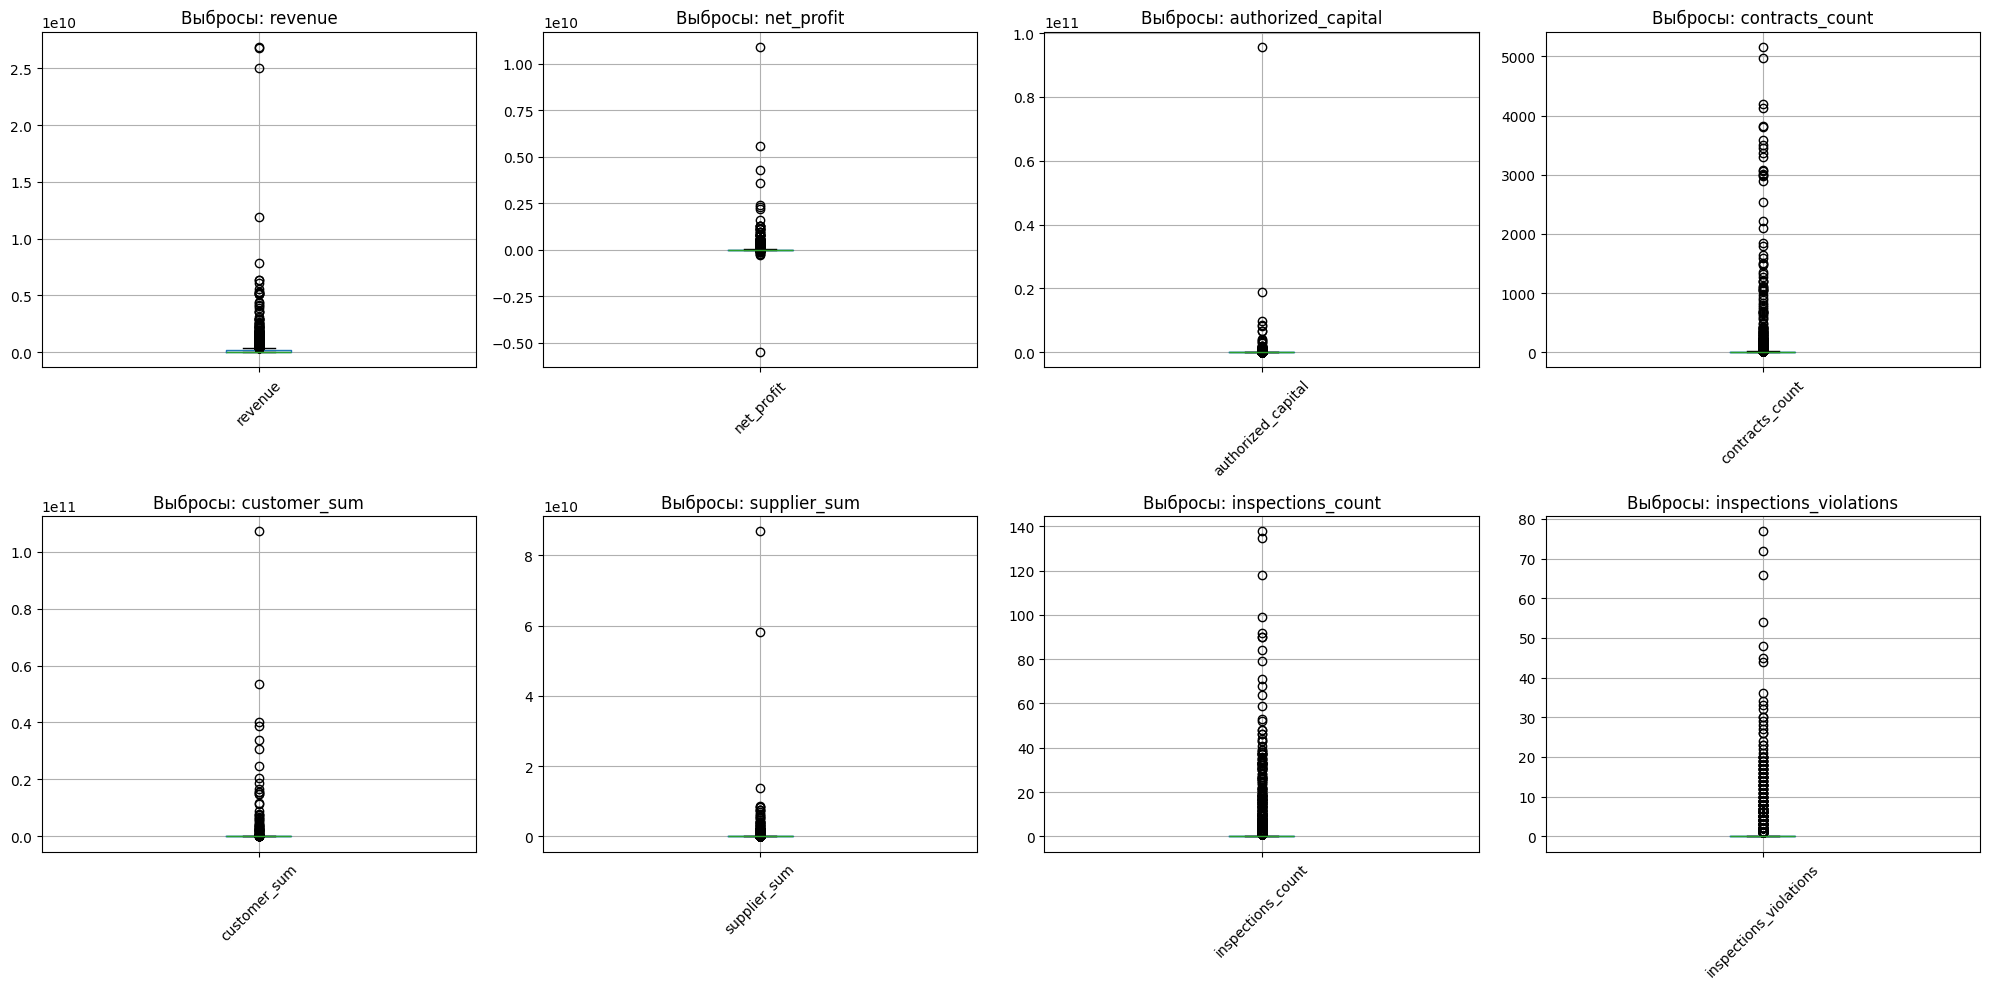

In [13]:
# Создаем графики для основных числовых переменных
main_numeric_cols = ['revenue', 'net_profit', 'authorized_capital', 'contracts_count', 
                    'customer_sum', 'supplier_sum', 'inspections_count', 'inspections_violations']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(main_numeric_cols[:8]):
    if col in df.columns and df[col].notna().sum() > 0:
        df.boxplot(column=col, ax=axes[i])
        axes[i].set_title(f'Выбросы: {col}')
        axes[i].tick_params(axis='x', rotation=45)

# Убираем лишние subplots
for i in range(len(main_numeric_cols), 8):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

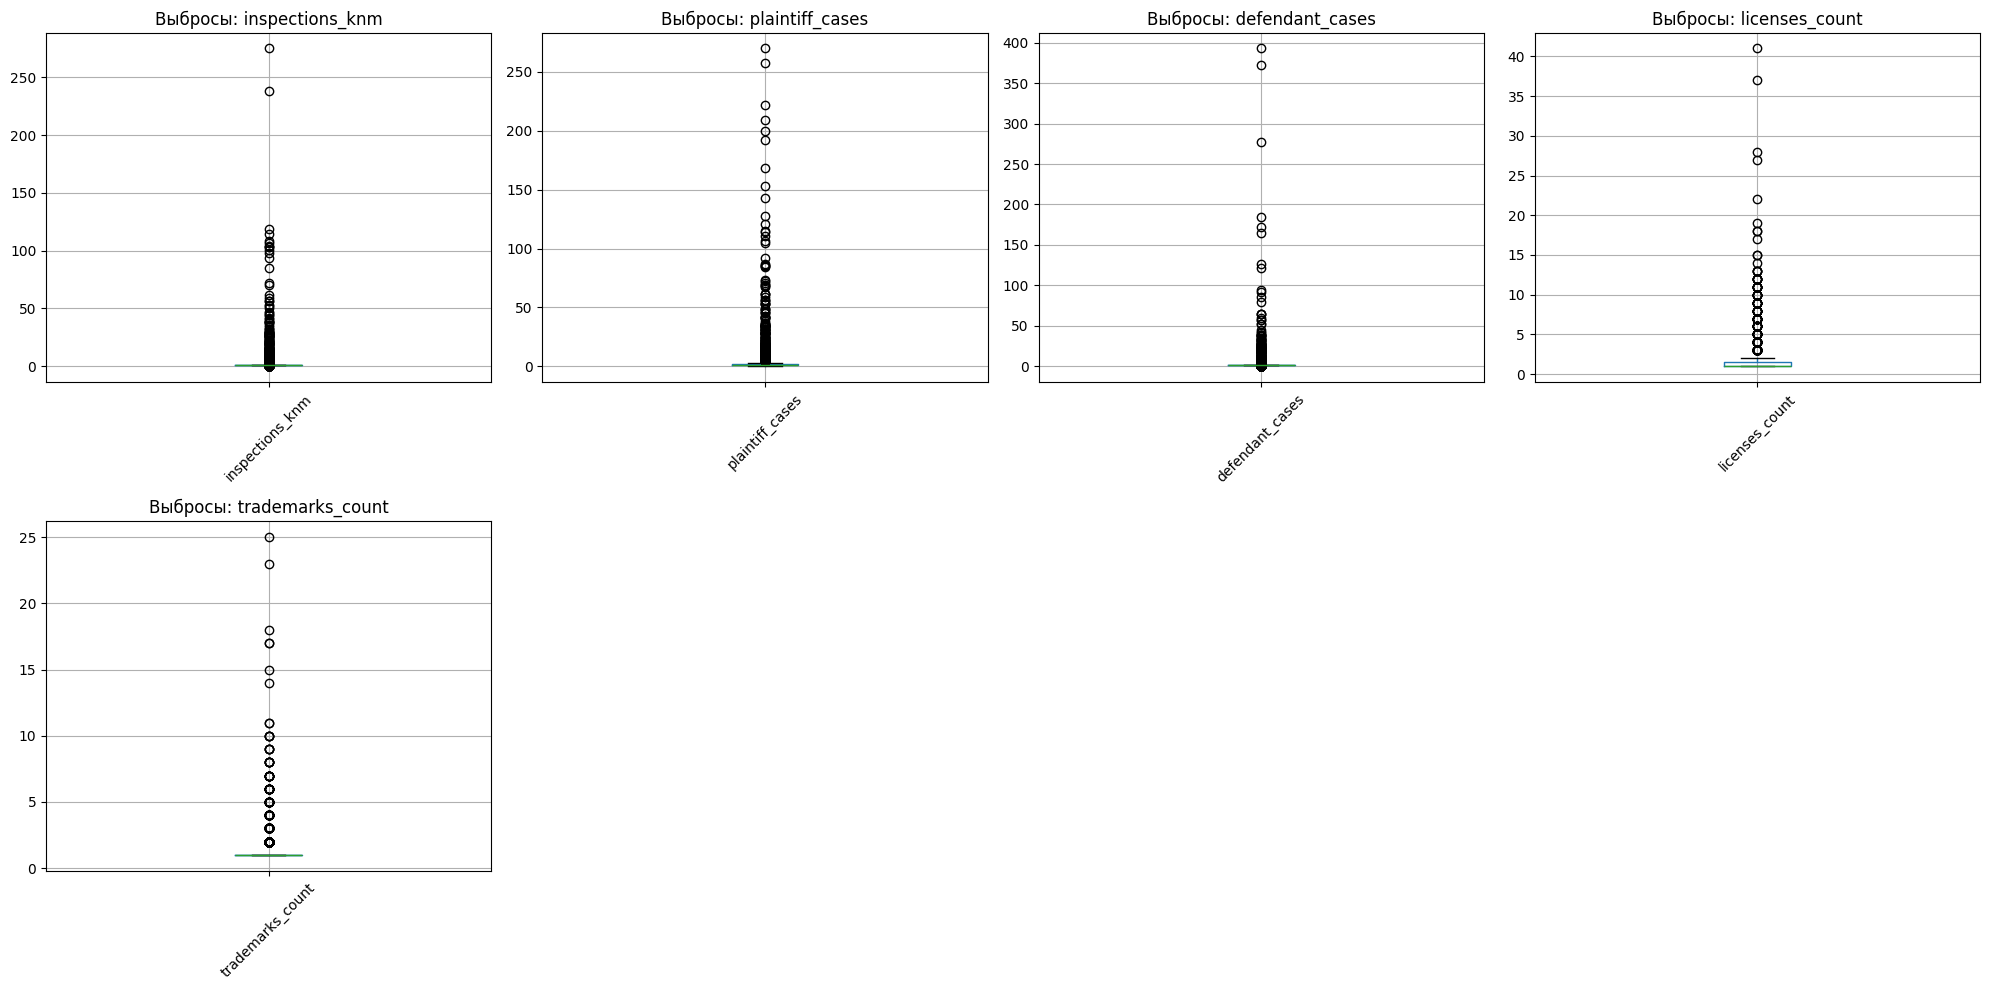

In [14]:
# Создаем графики для основных числовых переменных
main_numeric_cols = ['inspections_knm', 'plaintiff_cases', 'defendant_cases', 
                     'licenses_count', 'trademarks_count']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

for i, col in enumerate(main_numeric_cols[-7:]):
    if col in df.columns and df[col].notna().sum() > 0:
        df.boxplot(column=col, ax=axes[i])
        axes[i].set_title(f'Выбросы: {col}')
        axes[i].tick_params(axis='x', rotation=45)

for i in range(len(main_numeric_cols), 8):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

Удаление выбросов

In [15]:
def Del(df):
    """Удаляет строки с недопустимыми значениями в категориальных признаках"""
    
    initial_count = len(df)
    rows_to_drop = set()
    
    # Удаляем строки с недопустимыми значениями для company_type_numeric
    if 'company_type_numeric' in df.columns:
        invalid_mask = ~df['company_type_numeric'].between(1, 8)
        invalid_count = invalid_mask.sum()
        if invalid_count > 0:
            rows_to_drop.update(df[invalid_mask].index.tolist())
            print(f"Удалено {invalid_count} строк с недопустимыми значениями в 'company_type_numeric' (должно быть от 1 до 8)")
    
    # Удаляем строки с недопустимыми значениями для property_form_numeric
    if 'property_form_numeric' in df.columns:
        invalid_mask = ~df['property_form_numeric'].between(1, 11)
        invalid_count = invalid_mask.sum()
        if invalid_count > 0:
            rows_to_drop.update(df[invalid_mask].index.tolist())
            print(f"Удалено {invalid_count} строк с недопустимыми значениями в 'property_form_numeric' (должно быть от 1 до 11)")
    
    # Удаляем найденные строки
    if rows_to_drop:
        df_clean = df.drop(index=list(rows_to_drop))
        print(f"Всего удалено {len(rows_to_drop)} строк")
        print(f"Осталось {len(df_clean)} строк из исходных {initial_count}")
        return df_clean
    else:
        print("Недопустимых значений не найдено. Все строки остались без изменений.")
        return df


In [16]:
df = Del(df)

Недопустимых значений не найдено. Все строки остались без изменений.


4.2 Расчет описательных статистик

In [17]:
def calculate_descriptive_stats(df, numeric_columns):
    """Расчет описательных статистик для числовых переменных"""
    stats_df = pd.DataFrame(index=numeric_columns)
    
    for col in numeric_columns:
        if df[col].notna().sum() > 0:
            data = df[col].dropna()
            stats_df.loc[col, 'Количество'] = len(data)
            stats_df.loc[col, 'Среднее'] = data.mean()
            stats_df.loc[col, 'Дисперсия'] = data.var()
            stats_df.loc[col, 'Станд. отклонение'] = data.std()
            stats_df.loc[col, 'Мода'] = data.mode().iloc[0] if not data.mode().empty else np.nan
            stats_df.loc[col, 'Медиана'] = data.median()
            stats_df.loc[col, '1-й квартиль (Q1)'] = data.quantile(0.25)
            stats_df.loc[col, '3-й квартиль (Q3)'] = data.quantile(0.75)
            stats_df.loc[col, 'Коэф. вариации'] = (data.std() / data.mean()) * 100 if data.mean() != 0 else np.inf
            stats_df.loc[col, 'Асимметрия'] = stats.skew(data)
            stats_df.loc[col, 'Эксцесс'] = stats.kurtosis(data)
            stats_df.loc[col, 'Минимум'] = data.min()
            stats_df.loc[col, 'Максимум'] = data.max()
    
    return stats_df

In [18]:
# Статистики для числовых переменных
numeric_stats = calculate_descriptive_stats(df, numeric_columns)
print(numeric_stats.round(2))


                        Количество      Среднее              Дисперсия  \
revenue                    2233.00 260976727.27 1318008026415565568.00   
net_profit                 2917.00  34132183.41   88845764685372064.00   
authorized_capital         2917.00  75029593.56 3404852610809089024.00   
contracts_count            2917.00        54.51               98652.34   
customer_sum               2917.00 205635546.79 7868394530443161600.00   
supplier_sum               2917.00 168525656.39 4123362068116781056.00   
inspections_count          2917.00         1.83                  67.98   
inspections_violations     2917.00         0.85                  17.80   
inspections_knm            2917.00         2.86                 111.68   
plaintiff_cases            2917.00         4.01                 221.82   
defendant_cases            2917.00         2.81                 202.20   
licenses_count             2917.00         1.58                   4.04   
trademarks_count           2917.00    

In [19]:
# Статистики для категориальных переменных
categorical_columns = ['property_form_numeric', 'company_type_numeric']
print("\nОПИСАТЕЛЬНЫЕ СТАТИСТИКИ ДЛЯ КАЧЕСТВЕННЫХ ПЕРЕМЕННЫХ:")
print("-" * 80)

for col in categorical_columns:
    if col in df.columns:
        print(f"\n{col}:")
        value_counts = df[col].value_counts()
        print("Распределение значений:")
        for value, count in value_counts.items():
            percentage = (count / len(df)) * 100
            print(f"  {value}: {count} ({percentage:.1f}%)")


ОПИСАТЕЛЬНЫЕ СТАТИСТИКИ ДЛЯ КАЧЕСТВЕННЫХ ПЕРЕМЕННЫХ:
--------------------------------------------------------------------------------

property_form_numeric:
Распределение значений:
  11.0: 2767 (94.9%)
  10.0: 32 (1.1%)
  4.0: 29 (1.0%)
  8.0: 21 (0.7%)
  6.0: 18 (0.6%)
  1.0: 16 (0.5%)
  7.0: 14 (0.5%)
  2.0: 12 (0.4%)
  5.0: 4 (0.1%)
  9.0: 3 (0.1%)
  3.0: 1 (0.0%)

company_type_numeric:
Распределение значений:
  2: 2563 (87.9%)
  1: 331 (11.3%)
  3: 20 (0.7%)
  4: 3 (0.1%)


In [20]:
def check_normality(df, numeric_columns):
    """Проверка нормальности распределения"""
    normality_results = []
    
    for col in numeric_columns:
        if df[col].notna().sum() > 10:  # Минимум 10 наблюдений для тестов
            data = df[col].dropna()
            
            # a. Коэффициенты асимметрии и эксцесса
            skewness = stats.skew(data)
            kurtosis = stats.kurtosis(data)
            
            # b. Статистические тесты нормальности
            # Тест Шапиро-Уилка (для n < 5000)
            if len(data) <= 5000:
                shapiro_stat, shapiro_p = shapiro(data)
            else:
                shapiro_stat, shapiro_p = np.nan, np.nan
            
            # Тест Лиллиефорса
            lillie_stat, lillie_p = lilliefors(data, dist='norm')
            
            # Тест Харке-Бера (Jarque-Bera)
            jb_stat, jb_p = stats.jarque_bera(data)
            
            # Интерпретация результатов тестов
            alpha = 0.05
            tests_passed = 0
            total_tests = 3
            
            if not np.isnan(shapiro_p) and shapiro_p > alpha:
                tests_passed += 1
            if lillie_p > alpha:
                tests_passed += 1
            if jb_p > alpha:
                tests_passed += 1
            
            if tests_passed >= 2:
                normality_conclusion = "Нормальное"
            else:
                normality_conclusion = "Не нормальное"
            
            normality_results.append({
                'Переменная': col,
                'Асимметрия': round(skewness, 3),
                'Эксцесс': round(kurtosis, 3),
                'Shapiro-Wilk p-value': round(shapiro_p, 4) if not np.isnan(shapiro_p) else 'N/A',
                'Lilliefors p-value': round(lillie_p, 4),
                'Jarque-Bera p-value': round(jb_p, 4),
                'Тестов пройдено': f"{tests_passed}/{total_tests}",
                'Вывод': normality_conclusion
            })
    
    return pd.DataFrame(normality_results)

In [21]:
# Проверка нормальности для основных переменных

normality_df = check_normality(df, numeric_columns)
print(normality_df.to_string(index=False))


            Переменная  Асимметрия  Эксцесс  Shapiro-Wilk p-value  Lilliefors p-value  Jarque-Bera p-value Тестов пройдено         Вывод
               revenue       16.90   359.95                  0.00                0.00                 0.00             0/3 Не нормальное
            net_profit       19.05   711.43                  0.00                0.00                 0.00             0/3 Не нормальное
    authorized_capital       48.25  2475.62                  0.00                0.00                 0.00             0/3 Не нормальное
       contracts_count       10.33   120.51                  0.00                0.00                 0.00             0/3 Не нормальное
          customer_sum       25.19   814.33                  0.00                0.00                 0.00             0/3 Не нормальное
          supplier_sum       35.09  1372.62                  0.00                0.00                 0.00             0/3 Не нормальное
     inspections_count        8.55    97.

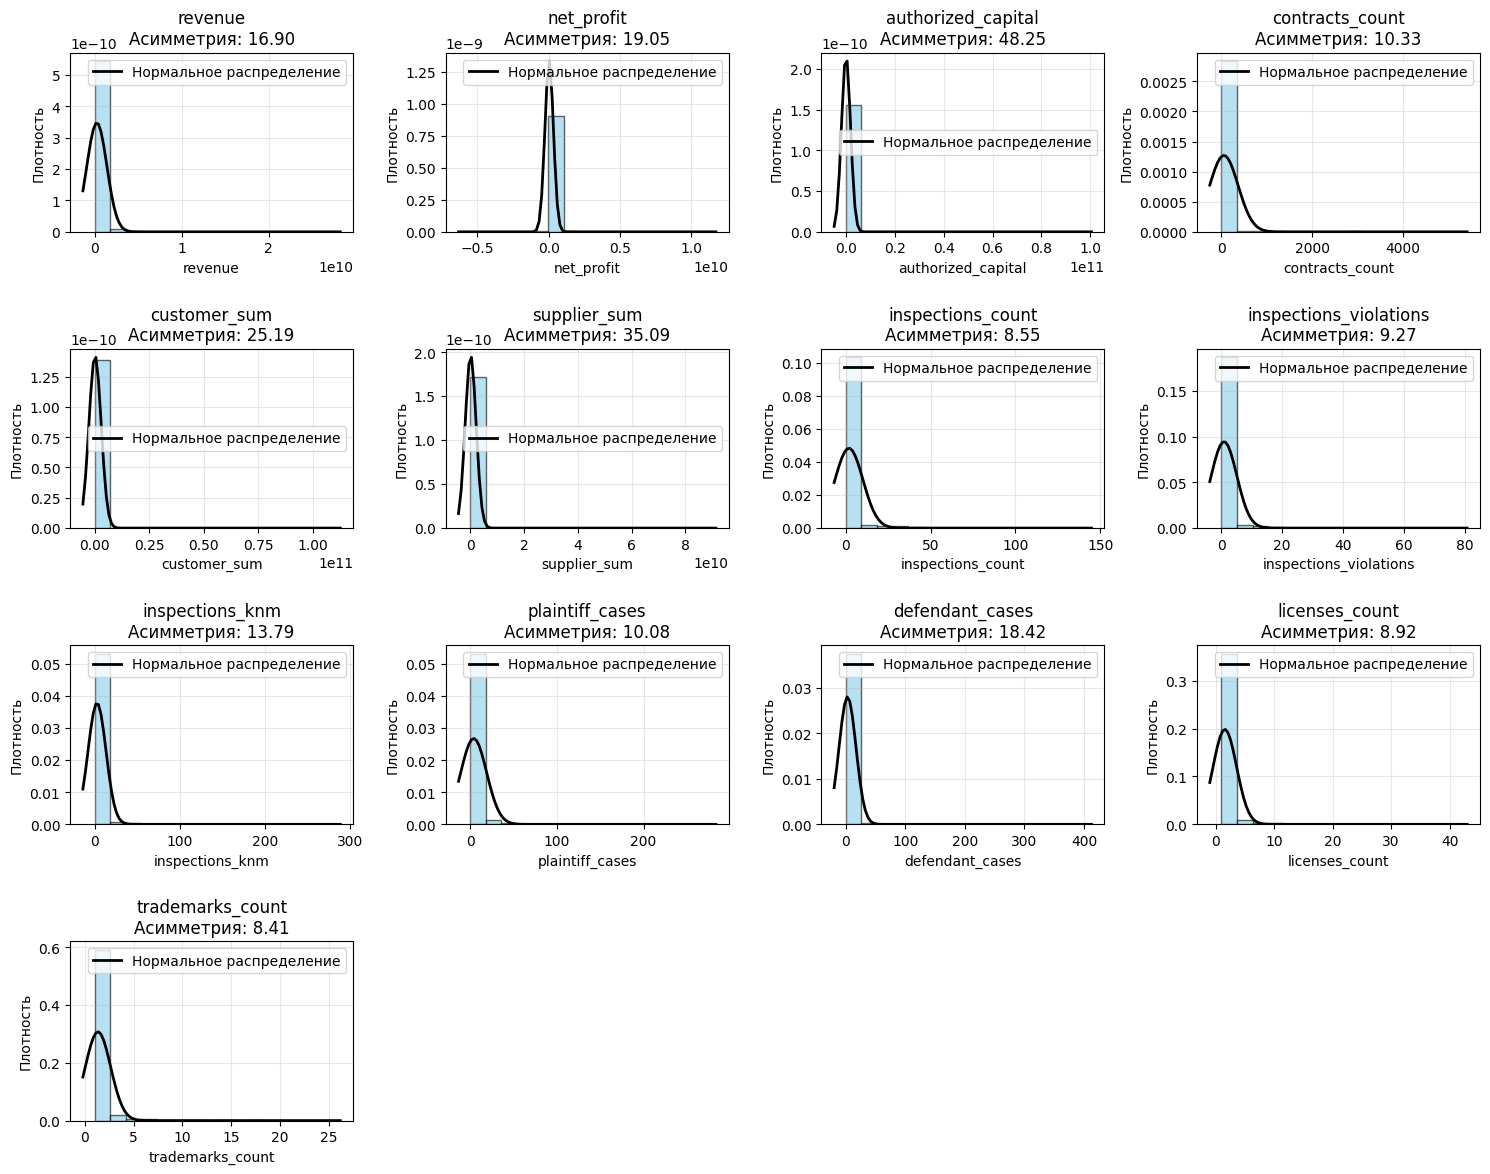

In [22]:
# a. Гистограммы с наложением плотности нормального распределения

fig, axes = plt.subplots(4, 4, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_columns):
    if col in df.columns and df[col].notna().sum() > 0:
        data = df[col].dropna()
        
        # Гистограмма
        axes[i].hist(data, bins=15, density=True, alpha=0.6, color='skyblue', edgecolor='black')
        
        # Наложение нормальной кривой
        xmin, xmax = axes[i].get_xlim()
        x = np.linspace(xmin, xmax, 100)
        if data.std() > 0:  # Избегаем деления на ноль
            p = norm.pdf(x, data.mean(), data.std())
            axes[i].plot(x, p, 'k', linewidth=2, label='Нормальное распределение')
        
        axes[i].set_title(f'{col}\nАсимметрия: {stats.skew(data):.2f}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Плотность')
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)

# Убираем лишние subplots
for i in range(len(numeric_columns), 16):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


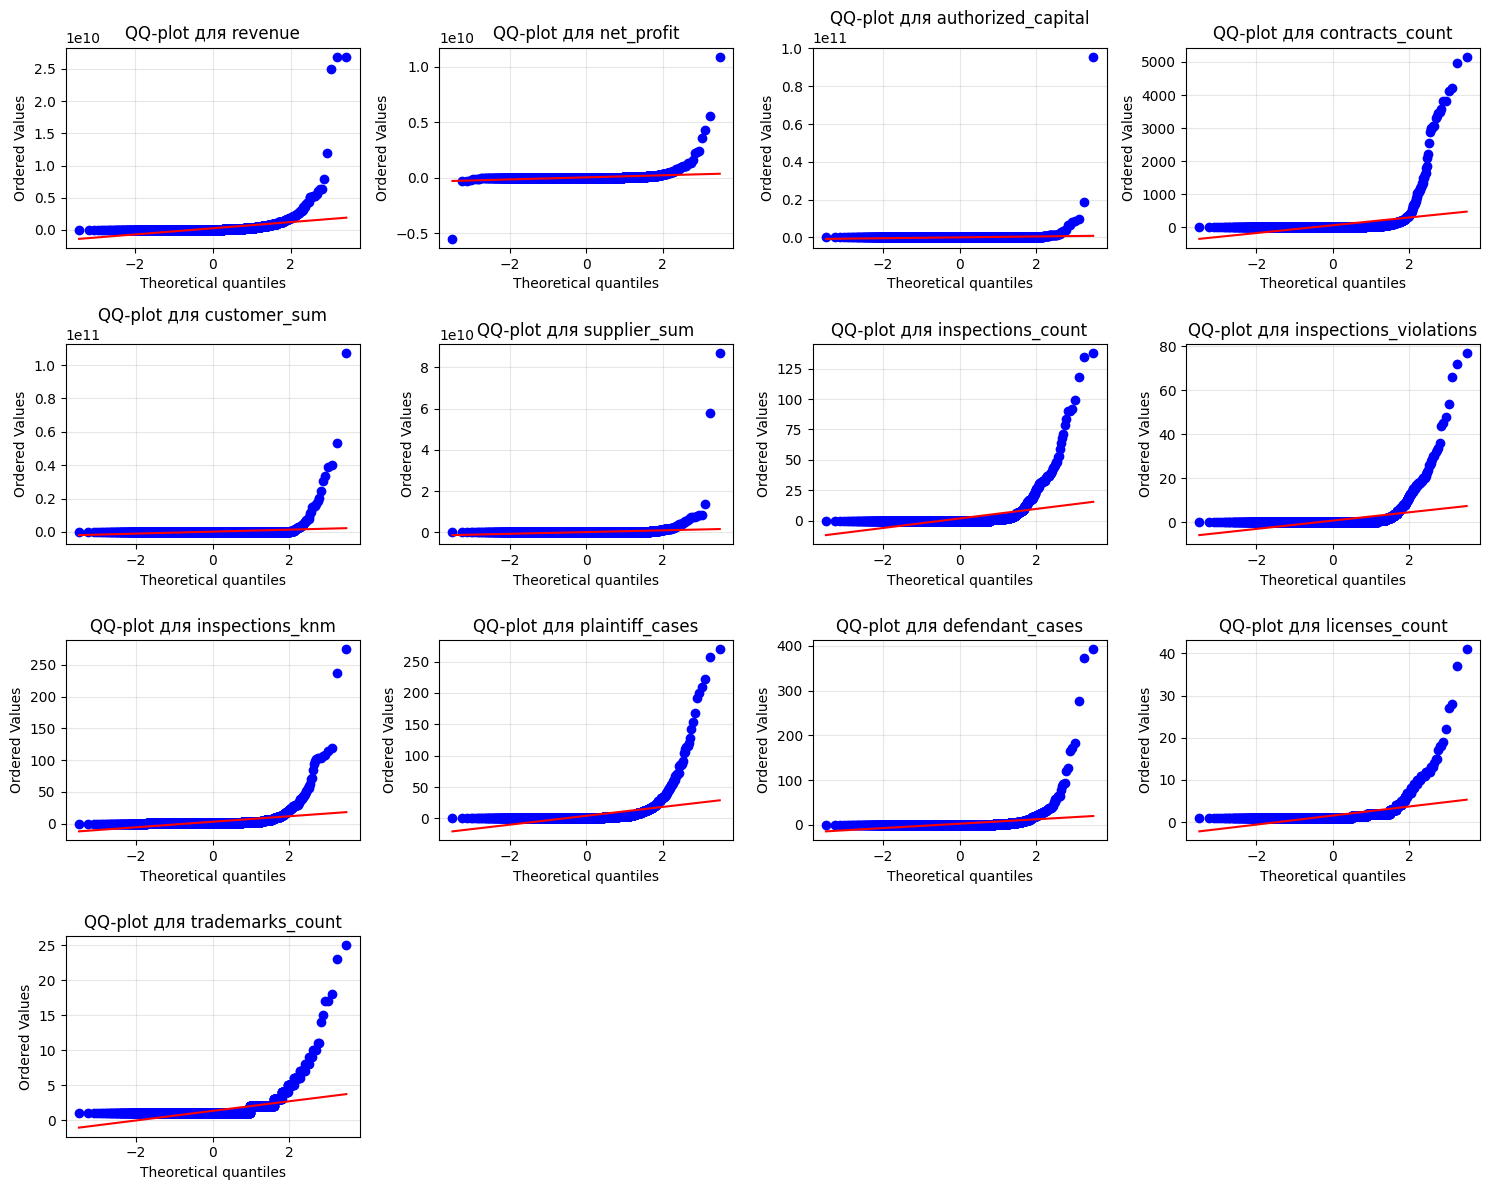

In [23]:
# b. Графики Квантиль-Квантиль (QQ-plot)

fig, axes = plt.subplots(4, 4, figsize=(15, 12))
axes = axes.ravel()

for i, col in enumerate(numeric_columns):
    if col in df.columns and df[col].notna().sum() > 0:
        data = df[col].dropna()
        
        # QQ-plot
        probplot(data, dist="norm", plot=axes[i])
        axes[i].set_title(f'QQ-plot для {col}')
        axes[i].grid(True, alpha=0.3)

# Убираем лишние subplots
for i in range(len(numeric_columns), 16):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

# Классификация


In [24]:
numeric_features = [
    'revenue', 'net_profit', 'authorized_capital', 
    'contracts_count', 'customer_sum', 'supplier_sum',
    'inspections_count', 'inspections_violations', 'inspections_knm',
    'plaintiff_cases', 'defendant_cases', 'licenses_count', 
    'trademarks_count'
]

# Оставляем только строки без пропусков в выбранных признаках
df_cluster = df[numeric_features].dropna()
print(f"Количество записей для кластеризации: {len(df_cluster)}")

Количество записей для кластеризации: 2233


In [25]:
# Логарифмическое преобразование для уменьшения асимметрии
df_log = df_cluster.copy()
for col in numeric_features:
    # Для net_profit (который может быть отрицательным) используем особый подход
    if col == 'net_profit':
        # Сдвигаем значения, чтобы все были положительными
        min_val = df_log[col].min()
        if min_val <= 0:
            shift = abs(min_val) + 1
            df_log[col] = np.log1p(df_log[col] + shift)
        else:
            df_log[col] = np.log1p(df_log[col])
    else:
        # Для остальных признаков
        if df_log[col].min() == 0:
            df_log[col] = np.log1p(df_log[col])
        else:
            df_log[col] = np.log(df_log[col])


In [26]:
# Проверка на наличие NaN после преобразования
nan_count = df_log.isna().sum().sum()
if nan_count > 0:
    print(f"\nВНИМАНИЕ: Обнаружено {nan_count} NaN значений после логарифмического преобразования")
    # Удаляем строки с NaN
    df_log = df_log.dropna()
    print(f"Количество записей после удаления NaN: {len(df_log)}")

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_log)

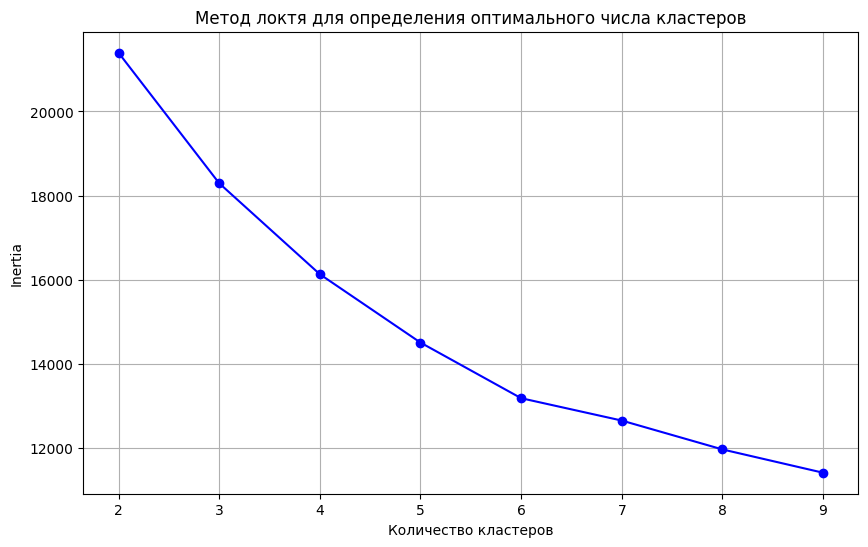

In [27]:
# Метод локтя
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

# Построение графика метода локтя
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, 'bo-')
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя для определения оптимального числа кластеров')
plt.grid(True)
plt.savefig('elbow_method.png', dpi=300, bbox_inches='tight')


In [28]:
# Метод силуэта
silhouette_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)
    print(f"Количество кластеров: {k}, Silhouette Score: {score:.4f}")

Количество кластеров: 2, Silhouette Score: 0.4531
Количество кластеров: 3, Silhouette Score: 0.3045
Количество кластеров: 4, Silhouette Score: 0.3666
Количество кластеров: 5, Silhouette Score: 0.3109
Количество кластеров: 6, Silhouette Score: 0.2018
Количество кластеров: 7, Silhouette Score: 0.1654
Количество кластеров: 8, Silhouette Score: 0.1632
Количество кластеров: 9, Silhouette Score: 0.1664


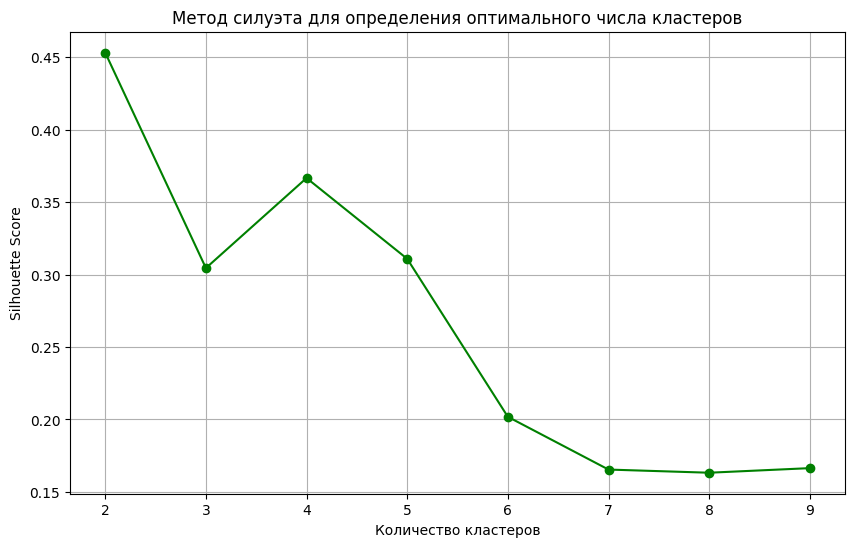

In [29]:
# Построение графика силуэта
plt.figure(figsize=(10, 6))
plt.plot(k_range, silhouette_scores, 'go-')
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.title('Метод силуэта для определения оптимального числа кластеров')
plt.grid(True)
plt.savefig('silhouette_method.png', dpi=300, bbox_inches='tight')

In [30]:
optimal_k = 3

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
df_cluster['cluster'] = clusters

# Анализ размера кластеров
cluster_sizes = df_cluster['cluster'].value_counts().sort_index()
print("\nРазмеры кластеров:")
for cluster, size in cluster_sizes.items():
    print(f"Кластер {cluster}: {size} компаний ({size/len(df_cluster)*100:.2f}%)")



Размеры кластеров:
Кластер 0: 725 компаний (32.47%)
Кластер 1: 1363 компаний (61.04%)
Кластер 2: 145 компаний (6.49%)


In [31]:
# Анализ центроидов
cluster_centers = pd.DataFrame(
    scaler.inverse_transform(np.exp(kmeans.cluster_centers_)), 
    columns=numeric_features
)
# Для логарифмически преобразованных данных возвращаем к исходному масштабу
for col in numeric_features:
    if df_cluster[col].min() == 0:
        cluster_centers[col] = np.expm1(cluster_centers[col])
    else:
        cluster_centers[col] = np.exp(cluster_centers[col])

print("\nХарактеристики центроидов кластеров:")
print(cluster_centers)


Характеристики центроидов кластеров:
          revenue   net_profit  authorized_capital  contracts_count  \
0   5676040358.23 505912746.71           710529.24            91.03   
1    119992302.03 424786075.97           207898.80            15.37   
2 154677614534.81 547300455.43       6548583721.46           398.05   

   customer_sum  supplier_sum  inspections_count  inspections_violations  \
0          3.10  544471378.56               1.55                    0.67   
1          2.87   27496061.43               1.04                    0.61   
2          9.34 8177550620.58          456110.73                36141.93   

   inspections_knm  plaintiff_cases  defendant_cases  licenses_count  \
0             2.92             8.14             2.44            2.70   
1             2.39             2.92             2.62            1.64   
2           446.73           365.77            25.00           22.76   

   trademarks_count  
0              2.47  
1              1.61  
2              3.

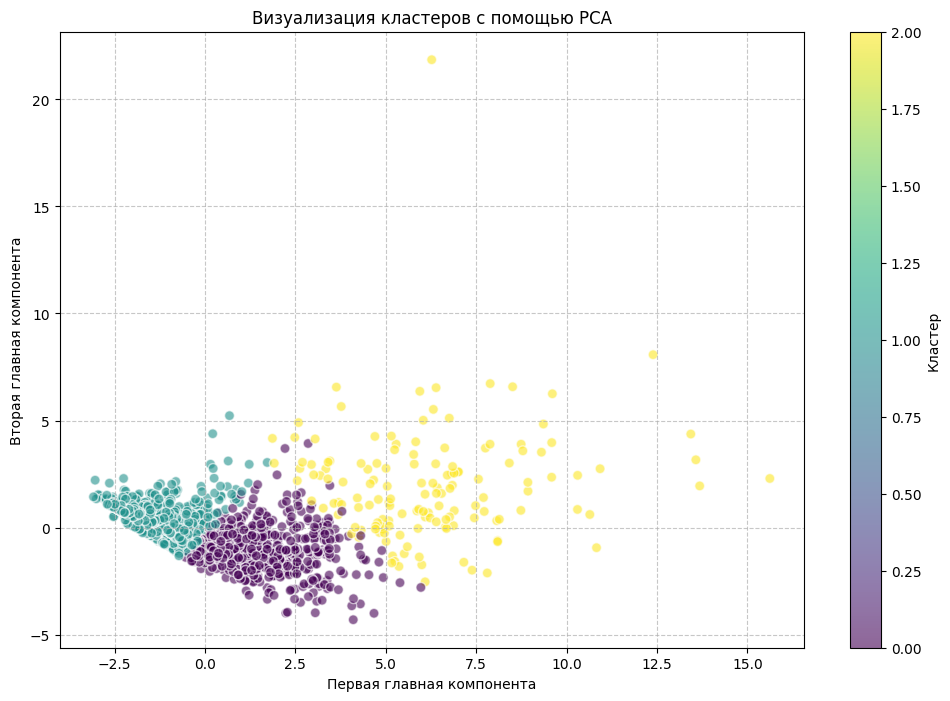

In [32]:
# Визуализация кластеров с помощью PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis', 
                     s=50, alpha=0.6, edgecolor='w')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Визуализация кластеров с помощью PCA')
plt.colorbar(scatter, label='Кластер')
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('clusters_pca.png', dpi=300, bbox_inches='tight')

Проверка на нормальность в кластерах

In [33]:
# Тесты на нормальность для каждого кластера и каждой переменной
normality_results = []
alpha = 0.05

for cluster in range(optimal_k):
    cluster_data = df_cluster[df_cluster['cluster'] == cluster]
    
    print(f"\nКластер {cluster}:")
    for col in numeric_features:
        # Shapiro-Wilk test
        stat, p_value = stats.shapiro(cluster_data[col])
        is_normal = p_value > alpha
        
        normality_results.append({
            'cluster': cluster,
            'variable': col,
            'shapiro_p': p_value,
            'normal': is_normal
        })
        
        status = "нормальное" if is_normal else "не нормальное"
        print(f"  - {col}: p-value = {p_value:.4f} - {status}")
    
    # Процент нормально распределенных переменных в кластере
    normal_count = sum(1 for res in normality_results if res['cluster'] == cluster and res['normal'])
    print(f"  - Нормально распределенных переменных: {normal_count}/{len(numeric_features)}")



Кластер 0:
  - revenue: p-value = 0.0000 - не нормальное
  - net_profit: p-value = 0.0000 - не нормальное
  - authorized_capital: p-value = 0.0000 - не нормальное
  - contracts_count: p-value = 0.0000 - не нормальное
  - customer_sum: p-value = 0.0000 - не нормальное
  - supplier_sum: p-value = 0.0000 - не нормальное
  - inspections_count: p-value = 0.0000 - не нормальное
  - inspections_violations: p-value = 0.0000 - не нормальное
  - inspections_knm: p-value = 0.0000 - не нормальное
  - plaintiff_cases: p-value = 0.0000 - не нормальное
  - defendant_cases: p-value = 0.0000 - не нормальное
  - licenses_count: p-value = 0.0000 - не нормальное
  - trademarks_count: p-value = 0.0000 - не нормальное
  - Нормально распределенных переменных: 0/13

Кластер 1:
  - revenue: p-value = 0.0000 - не нормальное
  - net_profit: p-value = 0.0000 - не нормальное
  - authorized_capital: p-value = 0.0000 - не нормальное
  - contracts_count: p-value = 0.0000 - не нормальное
  - customer_sum: p-value = 0

Корреляционный анализ

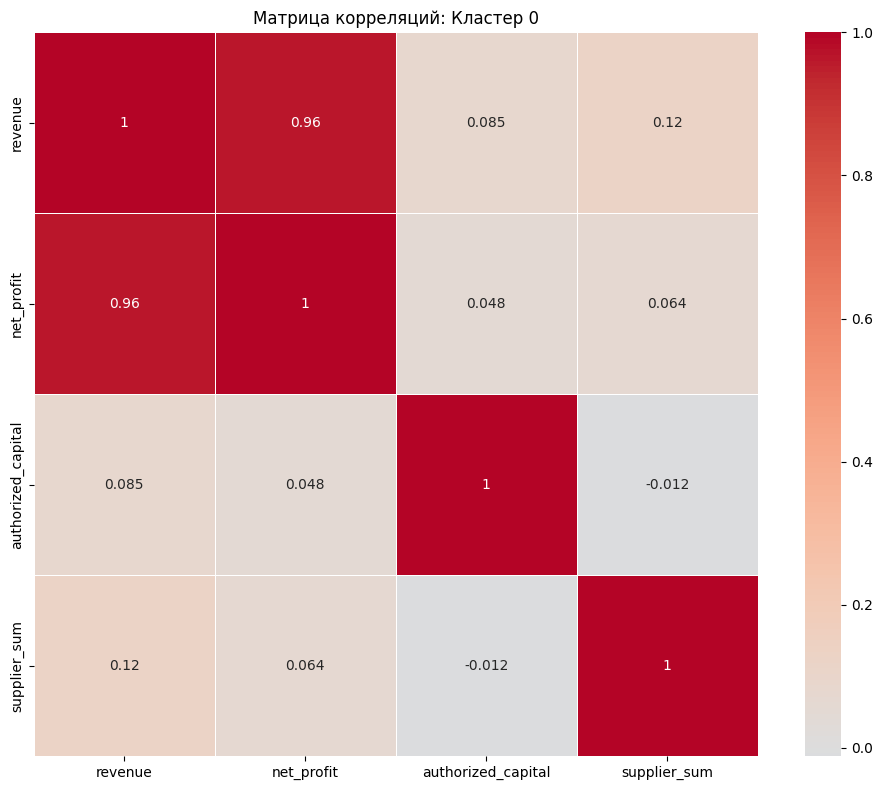


Анализ гетероскедастичности для кластера 0:
  Дисперсия net_profit в разных группах по revenue:
  Низкие: 3.01e+14, Средние: 1.49e+15, Высокие: 5.78e+17
  Соотношение дисперсий: 1921.86
Возможна гетероскедастичность


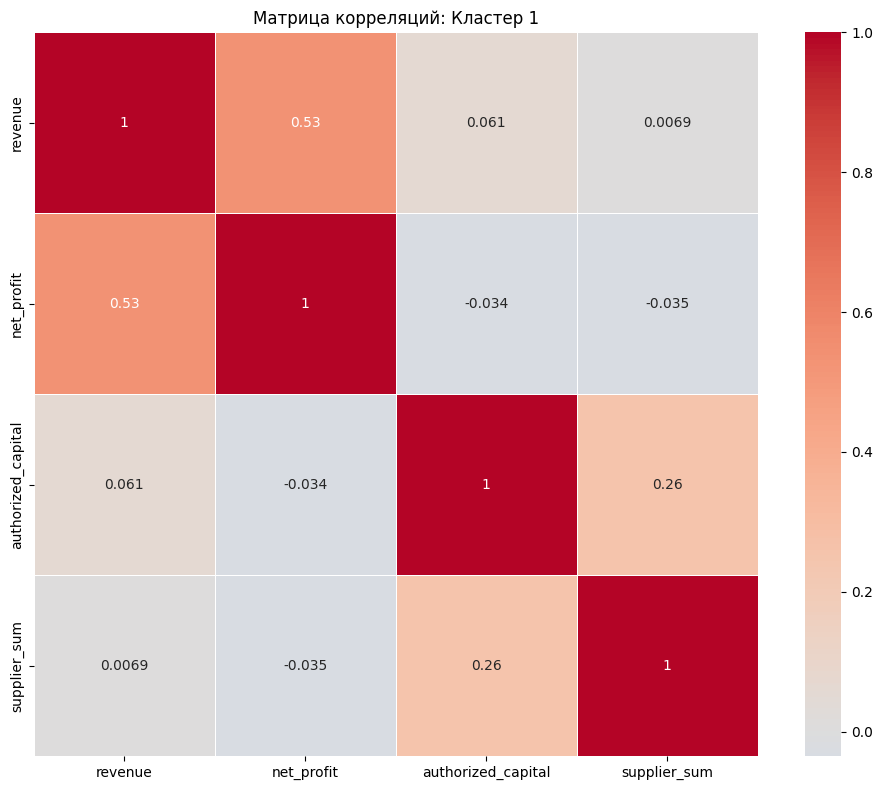


Анализ гетероскедастичности для кластера 1:
  Дисперсия net_profit в разных группах по revenue:
  Низкие: 1.96e+13, Средние: 1.77e+13, Высокие: 3.43e+14
  Соотношение дисперсий: 19.35
Возможна гетероскедастичность


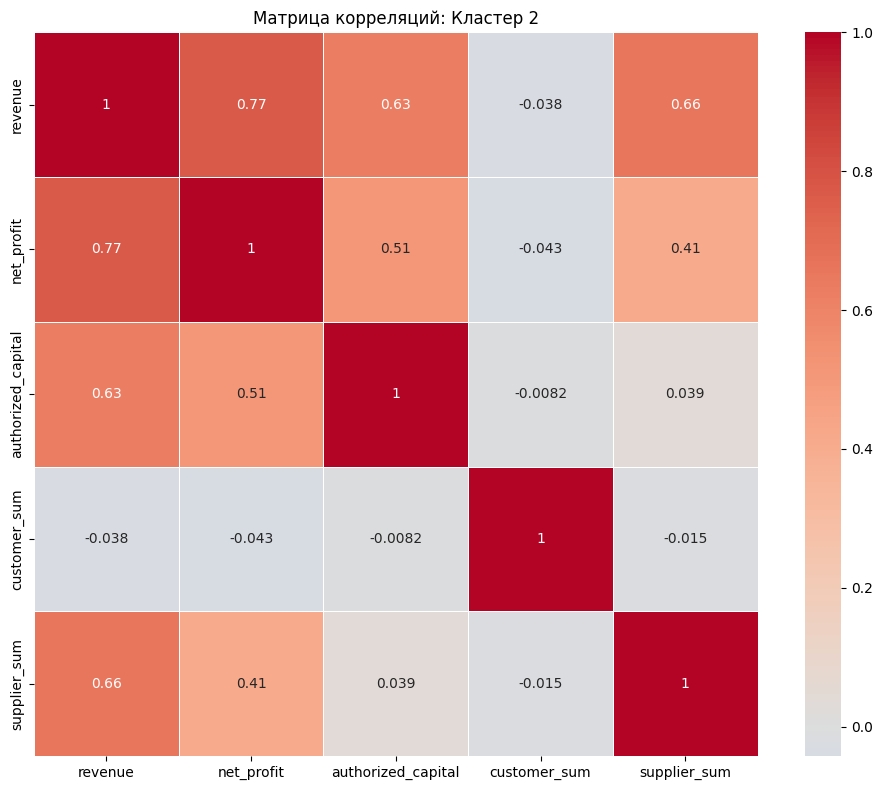


Анализ гетероскедастичности для кластера 2:
  Дисперсия net_profit в разных группах по revenue:
  Низкие: 2.01e+15, Средние: 8.94e+15, Высокие: 1.16e+18
  Соотношение дисперсий: 580.18
Возможна гетероскедастичность


In [37]:
def plot_correlation_fields(df, cluster_num, variables=None):
    """Строит поля корреляции для указанного кластера"""
    if variables is None:
        variables = ['revenue', 'net_profit', 'authorized_capital', 'customer_sum', 'supplier_sum']
    
    cluster_data = df[df['cluster'] == cluster_num]
    
    if len(cluster_data) < 2:
        print(f"В кластере {cluster_num} недостаточно данных для построения корреляции")
        return
    
    # Выбираем только непрерывные переменные
    continuous_vars = []
    for var in variables:
        if var in cluster_data.columns and cluster_data[var].nunique() > 6:  # эвристика для непрерывности
            continuous_vars.append(var)
    
    if len(continuous_vars) < 2:
        print(f"В кластере {cluster_num} недостаточно непрерывных переменных")
        return
    
    # Матрица корреляций
    corr_matrix = cluster_data[continuous_vars].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title(f'Матрица корреляций: Кластер {cluster_num}')
    plt.tight_layout()
    plt.show()

    # Анализ гетероскедастичности
    print(f"\nАнализ гетероскедастичности для кластера {cluster_num }:")
    if 'revenue' in continuous_vars and 'net_profit' in continuous_vars:
        # Простой тест на гетероскедастичность: сравниваем дисперсии в разных диапазонах
        x = cluster_data['revenue']
        y = cluster_data['net_profit']
        
        # Делим данные на три группы по revenue
        low_mask = x <= x.quantile(0.33)
        mid_mask = (x > x.quantile(0.33)) & (x <= x.quantile(0.66))
        high_mask = x > x.quantile(0.66)
        
        var_low = y[low_mask].var()
        var_mid = y[mid_mask].var()
        var_high = y[high_mask].var()
        
        max_var = max(var_low, var_mid, var_high)
        min_var = min(var_low, var_mid, var_high)
        
        heteroscedasticity_ratio = max_var / min_var if min_var > 0 else np.inf
        
        print(f"  Дисперсия net_profit в разных группах по revenue:")
        print(f"  Низкие: {var_low:.2e}, Средние: {var_mid:.2e}, Высокие: {var_high:.2e}")
        print(f"  Соотношение дисперсий: {heteroscedasticity_ratio:.2f}")
        
        if heteroscedasticity_ratio > 4:  # эвристический порог
            print("Возможна гетероскедастичность")
        else:
            print("Гомоскедастичность вероятна")

# Строим поля корреляции для каждого кластера
for cluster in sorted(df_cluster['cluster'].unique()):
    plot_correlation_fields(df_cluster, cluster)

# Корреляционный анализ

In [42]:
# Создаем словарь для хранения результатов
quantitative_columns = ['revenue', 'net_profit', 'authorized_capital', 'customer_sum', 'supplier_sum'] 
qualitative_columns = [
    'contracts_count',
    'inspections_count', 'inspections_violations', 'inspections_knm',
    'plaintiff_cases', 'defendant_cases', 'licenses_count', 
    'trademarks_count'
]



Парные корреляции Пирсона (количественные переменные):

Коэффициенты корреляции Пирсона:
revenue - net_profit: 0.962 *** (p-value: 0.0000)
revenue - authorized_capital: 0.085 * (p-value: 0.0228)
revenue - customer_sum: 0.033 незнач. (p-value: 0.3812)
revenue - supplier_sum: 0.123 *** (p-value: 0.0009)
net_profit - authorized_capital: 0.048 незнач. (p-value: 0.1996)
net_profit - customer_sum: 0.025 незнач. (p-value: 0.5053)
net_profit - supplier_sum: 0.064 незнач. (p-value: 0.0863)
authorized_capital - customer_sum: 0.017 незнач. (p-value: 0.6417)
authorized_capital - supplier_sum: -0.012 незнач. (p-value: 0.7541)
customer_sum - supplier_sum: -0.008 незнач. (p-value: 0.8292)


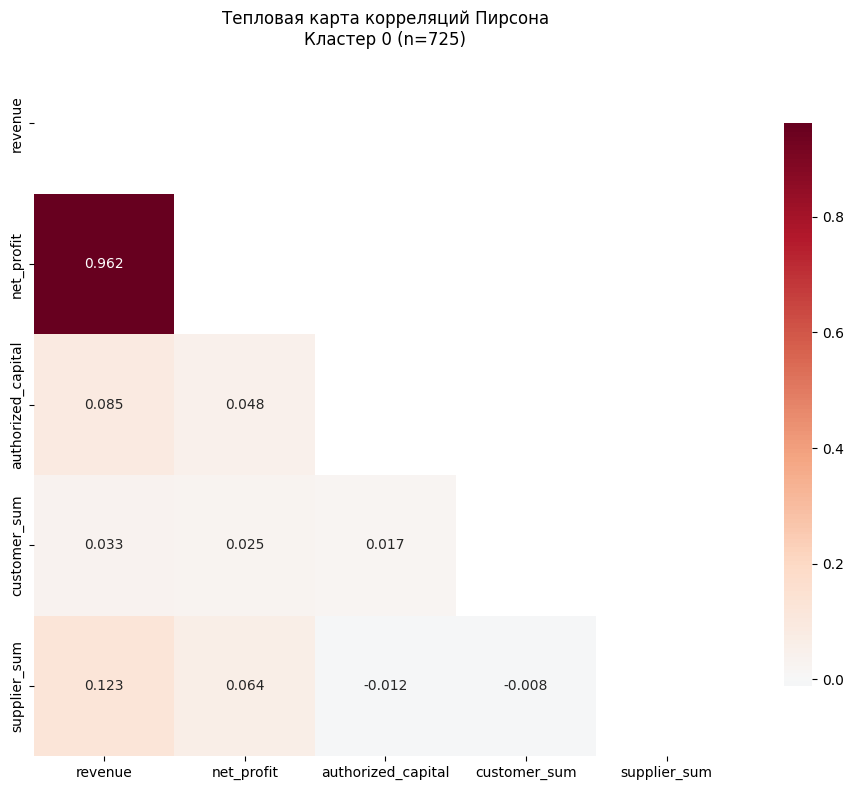


Анализ мультиколлинеарности:
Обнаружены высокие значимые корреляции (|r| > 0.7):
  revenue - net_profit: r = 0.962
ВНИМАНИЕ: Возможна мультиколлинеарность!

Ранговые корреляции Спирмена (качественные vs количественные):

Качественная переменная: contracts_count
  contracts_count - revenue: ρ = 0.115 ** (p-value: 0.0019)
  contracts_count - net_profit: ρ = 0.093 * (p-value: 0.0123)
  contracts_count - authorized_capital: ρ = 0.036 незнач. (p-value: 0.3383)
  contracts_count - customer_sum: ρ = 0.107 ** (p-value: 0.0040)
  contracts_count - supplier_sum: ρ = 0.653 *** (p-value: 0.0000)

Качественная переменная: inspections_count
  inspections_count - revenue: ρ = 0.364 *** (p-value: 0.0000)
  inspections_count - net_profit: ρ = 0.204 *** (p-value: 0.0000)
  inspections_count - authorized_capital: ρ = 0.096 ** (p-value: 0.0097)
  inspections_count - customer_sum: ρ = -0.009 незнач. (p-value: 0.8144)
  inspections_count - supplier_sum: ρ = 0.171 *** (p-value: 0.0000)

Качественная перемен

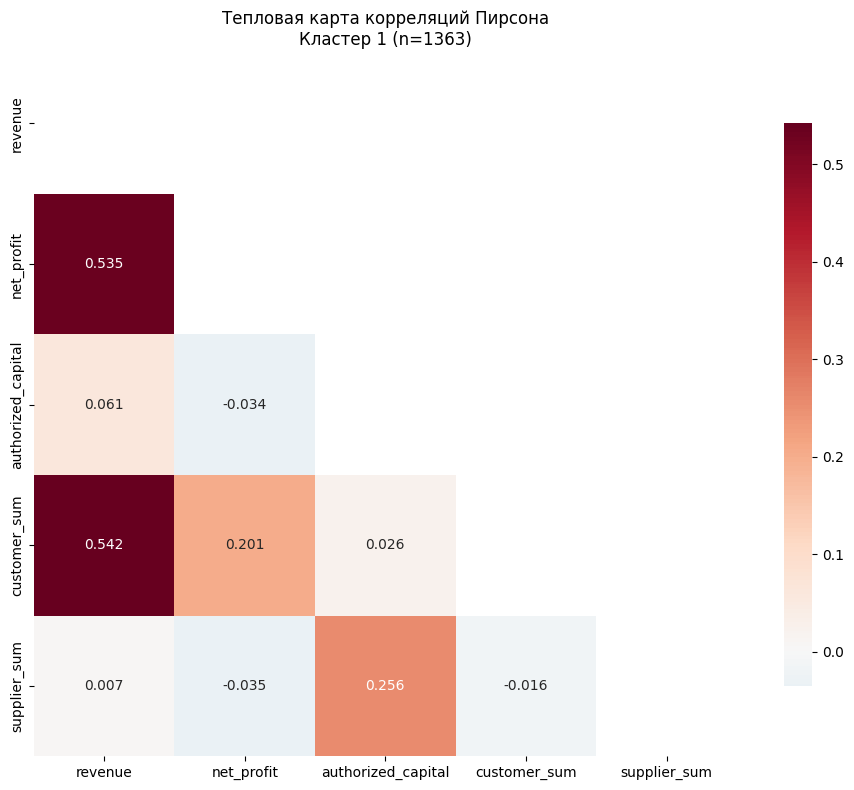


Анализ мультиколлинеарности:
Высоких корреляций не обнаружено

Ранговые корреляции Спирмена (качественные vs количественные):

Качественная переменная: contracts_count
  contracts_count - revenue: ρ = 0.343 *** (p-value: 0.0000)
  contracts_count - net_profit: ρ = 0.218 *** (p-value: 0.0000)
  contracts_count - authorized_capital: ρ = 0.016 незнач. (p-value: 0.5452)
  contracts_count - customer_sum: ρ = 0.061 * (p-value: 0.0235)
  contracts_count - supplier_sum: ρ = 0.675 *** (p-value: 0.0000)

Качественная переменная: inspections_count
  inspections_count - revenue: ρ = 0.059 * (p-value: 0.0291)
  inspections_count - net_profit: ρ = 0.007 незнач. (p-value: 0.7900)
  inspections_count - authorized_capital: ρ = 0.058 * (p-value: 0.0327)
  inspections_count - customer_sum: ρ = -0.010 незнач. (p-value: 0.7071)
  inspections_count - supplier_sum: ρ = -0.002 незнач. (p-value: 0.9365)

Качественная переменная: inspections_violations
  inspections_violations - revenue: ρ = 0.040 незнач. (p-v

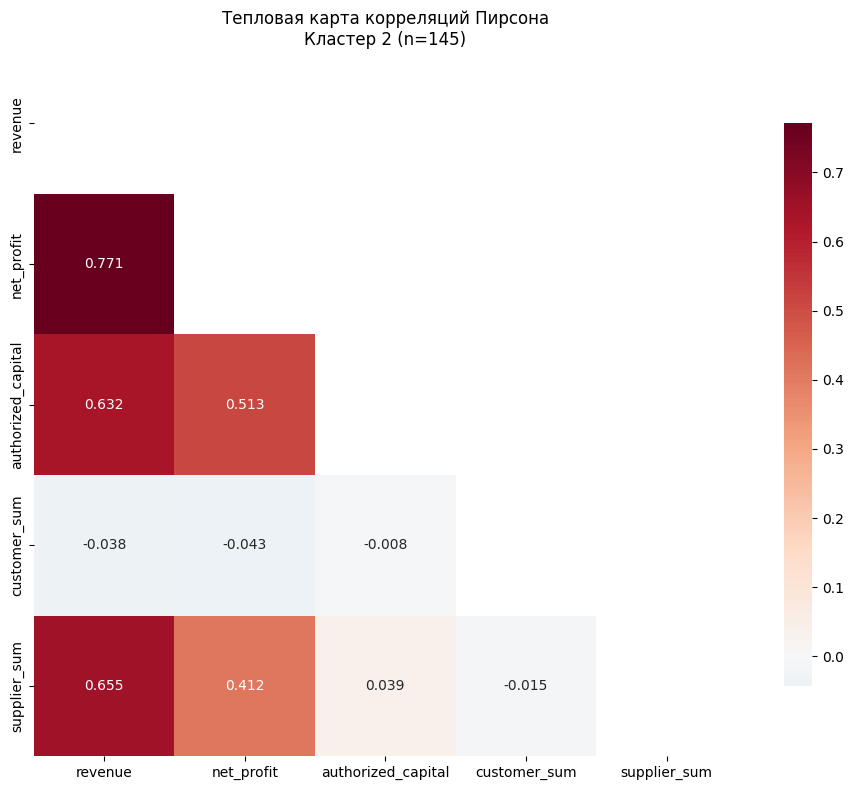


Анализ мультиколлинеарности:
Обнаружены высокие значимые корреляции (|r| > 0.7):
  revenue - net_profit: r = 0.771
ВНИМАНИЕ: Возможна мультиколлинеарность!

Ранговые корреляции Спирмена (качественные vs количественные):

Качественная переменная: contracts_count
  contracts_count - revenue: ρ = 0.280 *** (p-value: 0.0006)
  contracts_count - net_profit: ρ = 0.243 ** (p-value: 0.0032)
  contracts_count - authorized_capital: ρ = -0.048 незнач. (p-value: 0.5640)
  contracts_count - customer_sum: ρ = 0.181 * (p-value: 0.0292)
  contracts_count - supplier_sum: ρ = 0.764 *** (p-value: 0.0000)

Качественная переменная: inspections_count
  inspections_count - revenue: ρ = 0.015 незнач. (p-value: 0.8614)
  inspections_count - net_profit: ρ = -0.024 незнач. (p-value: 0.7720)
  inspections_count - authorized_capital: ρ = 0.176 * (p-value: 0.0345)
  inspections_count - customer_sum: ρ = 0.089 незнач. (p-value: 0.2867)
  inspections_count - supplier_sum: ρ = -0.005 незнач. (p-value: 0.9503)

Качест

In [45]:
# Анализ по кластерам
for cluster_num in range(3):

    # Данки текущего кластера
    cluster_data = df_cluster[df_cluster['cluster'] == cluster_num]
    
    # 1. КОРРЕЛЯЦИЯ ПИРСОНА ДЛЯ КОЛИЧЕСТВЕННЫХ ПЕРЕМЕННЫХ
    print(f"\nПарные корреляции Пирсона (количественные переменные):")
    
    # Создаем матрицы для корреляций и p-значений
    corr_matrix = cluster_data[quantitative_columns].corr(method='pearson')
    p_value_matrix = np.zeros((len(quantitative_columns), len(quantitative_columns)))
    
    # Заполняем матрицу p-значений
    for i, col1 in enumerate(quantitative_columns):
        for j, col2 in enumerate(quantitative_columns):
            if i != j:
                corr, p_value = pearsonr(cluster_data[col1].dropna(), cluster_data[col2].dropna())
                p_value_matrix[i, j] = p_value
    
    # Выводим результаты корреляций
    print("\nКоэффициенты корреляции Пирсона:")
    for i, col1 in enumerate(quantitative_columns):
        for j, col2 in enumerate(quantitative_columns):
            if i < j:  # Выводим только уникальные пары
                corr_value = corr_matrix.iloc[i, j]
                p_value = p_value_matrix[i, j]
                significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "незнач."
                print(f"{col1} - {col2}: {corr_value:.3f} {significance} (p-value: {p_value:.4f})")
    
    # 2. ТЕПЛОВАЯ КАРТА КОРРЕЛЯЦИЙ ПИРСОНА
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Маска для верхнего треугольника
    
    sns.heatmap(corr_matrix, 
                mask=mask,
                annot=True, 
                cmap='RdBu_r', 
                center=0,
                square=True, 
                fmt='.3f',
                cbar_kws={'shrink': 0.8})
    
    plt.title(f'Тепловая карта корреляций Пирсона\nКластер {cluster_num} (n={len(cluster_data)})')
    plt.tight_layout()
    plt.show()
    
    # 3. АНАЛИЗ МУЛЬТИКОЛЛИНЕАРНОСТИ
    print(f"\nАнализ мультиколлинеарности:")
    high_corr_pairs = []
    for i, col1 in enumerate(quantitative_columns):
        for j, col2 in enumerate(quantitative_columns):
            if i < j and abs(corr_matrix.iloc[i, j]) > 0.7 and p_value_matrix[i, j] < 0.05:
                high_corr_pairs.append((col1, col2, corr_matrix.iloc[i, j]))
    
    if high_corr_pairs:
        print("Обнаружены высокие значимые корреляции (|r| > 0.7):")
        for pair in high_corr_pairs:
            print(f"  {pair[0]} - {pair[1]}: r = {pair[2]:.3f}")
        print("ВНИМАНИЕ: Возможна мультиколлинеарность!")
    else:
        print("Высоких корреляций не обнаружено")
    
    # 4. КОРРЕЛЯЦИЯ СПИРМЕНА ДЛЯ КАЧЕСТВЕННЫХ ПЕРЕМЕННЫХ
    if qualitative_columns:
        print(f"\nРанговые корреляции Спирмена (качественные vs количественные):")
        
        for qual_col in qualitative_columns:
            if qual_col in cluster_data.columns:
                print(f"\nКачественная переменная: {qual_col}")
                
                for quant_col in quantitative_columns:
                    # Удаляем пропущенные значения для пары переменных
                    valid_data = cluster_data[[qual_col, quant_col]].dropna()
                    
                    if len(valid_data) > 1:
                        corr_spearman, p_value_spearman = spearmanr(valid_data[qual_col], 
                                                                   valid_data[quant_col])
                        significance = "***" if p_value_spearman < 0.001 else "**" if p_value_spearman < 0.01 else "*" if p_value_spearman < 0.05 else "незнач."
                        
                        print(f"  {qual_col} - {quant_col}: ρ = {corr_spearman:.3f} {significance} (p-value: {p_value_spearman:.4f})")
                    else:
                        print(f"  {qual_col} - {quant_col}: недостаточно данных для анализа")




In [71]:
dependent_var = 'revenue'
independent_vars  = [
    'net_profit', 'authorized_capital', 'contracts_count', 
    'supplier_sum', 'inspections_count', 'plaintiff_cases',
    'defendant_cases', 'licenses_count', 'trademarks_count'
]

In [79]:
# Функция для расчета AIC и BIC
def calculate_aic_bic(y_true, y_pred, n_features):
    n = len(y_true)
    residuals = y_true - y_pred
    sse = np.sum(residuals**2)
    
    # AIC
    aic = n * np.log(sse / n) + 2 * n_features
    
    # BIC
    bic = n * np.log(sse / n) + n_features * np.log(n)
    
    return aic, bic

# Функция для расчета adjusted R²
def calculate_adj_r2(r2, n, k):
    return 1 - (1 - r2) * (n - 1) / (n - k - 1)

# Функция для F-теста
def f_test(y_true, y_pred, n_features):
    n = len(y_true)
    y_mean = np.mean(y_true)
    
    # Sum of squares
    sst = np.sum((y_true - y_mean)**2)  # Total sum of squares
    ssr = np.sum((y_pred - y_mean)**2)  # Regression sum of squares
    sse = np.sum((y_true - y_pred)**2)  # Error sum of squares
    
    # Degrees of freedom
    df_reg = n_features
    df_resid = n - n_features - 1
    
    # Mean squares
    msr = ssr / df_reg
    mse = sse / df_resid
    
    # F-statistic
    f_stat = msr / mse
    
    # p-value
    p_value = 1 - stats.f.cdf(f_stat, df_reg, df_resid)
    
    return f_stat, p_value

# Функция для теста Рамсея (RESET test)
def ramsey_reset_test(y_true, y_pred, X, alpha=0.05):
    """
    Упрощенная версия теста Рамсея на функциональную форму
    """
    try:
        n = len(y_true)
        # Добавляем квадраты предсказаний
        y_pred_sq = y_pred**2
        y_pred_cb = y_pred**3
        
        # Создаем расширенную матрицу признаков
        X_extended = np.column_stack([X, y_pred_sq, y_pred_cb])
        
        # Проверяем значимость добавленных членов
        model_extended = LinearRegression()
        model_extended.fit(X_extended, y_true)
        y_pred_extended = model_extended.predict(X_extended)
        
        # F-тест для сравнения моделей
        sse_reduced = np.sum((y_true - y_pred)**2)
        sse_full = np.sum((y_true - y_pred_extended)**2)
        
        df_reduced = X.shape[1]
        df_full = X_extended.shape[1]
        
        f_stat = ((sse_reduced - sse_full) / (df_full - df_reduced)) / (sse_full / (n - df_full - 1))
        p_value = 1 - stats.f.cdf(f_stat, df_full - df_reduced, n - df_full - 1)
        
        return f_stat, p_value
    except:
        return np.nan, np.nan

In [80]:
results_summary = []

In [82]:
for cluster_num in range(optimal_k):
    print(f"\n{'='*60}")
    print(f"КЛАСТЕР {cluster_num} - РЕГРЕССИОННЫЙ АНАЛИЗ")
    print(f"{'='*60}")
    
    # Данные текущего кластера
    cluster_data = df_cluster[df_cluster['cluster'] == cluster_num].copy()
    
    if len(cluster_data) < 10:
        print(f"В кластере {cluster_num} недостаточно данных для регрессионного анализа")
        continue
    
    # Разделяем на обучающую и тестовую выборки
    X = cluster_data[independent_vars].values
    y = cluster_data[dependent_var].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    print(f"Размер обучающей выборки: {len(X_train)}")
    print(f"Размер тестовой выборки: {len(X_test)}")
    
    # МОДЕЛЬ 1: Линейная регрессия
    print(f"\n--- МОДЕЛЬ 1: Линейная регрессия ---")
    
    try:
        model_linear = LinearRegression()
        model_linear.fit(X_train, y_train)
        y_pred_linear = model_linear.predict(X_test)
        
        # Метрики качества
        r2_linear = r2_score(y_test, y_pred_linear)
        mse_linear = mean_squared_error(y_test, y_pred_linear)
        mae_linear = mean_absolute_error(y_test, y_pred_linear)
        adj_r2_linear = calculate_adj_r2(r2_linear, len(y_test), X_test.shape[1])
        aic_linear, bic_linear = calculate_aic_bic(y_test, y_pred_linear, X_test.shape[1])
        f_stat_linear, f_pvalue_linear = f_test(y_test, y_pred_linear, X_test.shape[1])
        
        # Тест Рамсея
        reset_f_linear, reset_p_linear = ramsey_reset_test(y_test, y_pred_linear, X_test)
        
        print(f"R²: {r2_linear:.4f}")
        print(f"Adj R²: {adj_r2_linear:.4f}")
        print(f"MSE: {mse_linear:.4f}")
        print(f"MAE: {mae_linear:.4f}")
        print(f"AIC: {aic_linear:.4f}")
        print(f"BIC: {bic_linear:.4f}")
        print(f"F-статистика: {f_stat_linear:.4f}")
        print(f"p-value F-теста: {f_pvalue_linear:.4f}")
        print(f"Тест Рамсея p-value: {reset_p_linear:.4f}")
        
    except Exception as e:
        print(f"Ошибка в линейной модели: {e}")
        model_linear = None
    
    # МОДЕЛЬ 2: Логарифмическая модель
    print(f"\n--- МОДЕЛЬ 2: Логарифмическая (log(y)) ---")
    
    try:
        # Применяем логарифм к целевой переменной
        y_train_log = np.log(y_train + 1e-6)
        
        model_log = LinearRegression()
        model_log.fit(X_train, y_train_log)
        y_pred_log = model_log.predict(X_test)
        
        # Преобразуем обратно
        y_pred_log_exp = np.exp(y_pred_log) - 1e-6
        
        # Метрики качества
        r2_log = r2_score(y_test, y_pred_log_exp)
        mse_log = mean_squared_error(y_test, y_pred_log_exp)
        mae_log = mean_absolute_error(y_test, y_pred_log_exp)
        adj_r2_log = calculate_adj_r2(r2_log, len(y_test), X_test.shape[1])
        aic_log, bic_log = calculate_aic_bic(y_test, y_pred_log_exp, X_test.shape[1])
        f_stat_log, f_pvalue_log = f_test(y_test, y_pred_log_exp, X_test.shape[1])
        
        # Тест Рамсея
        reset_f_log, reset_p_log = ramsey_reset_test(y_test, y_pred_log_exp, X_test)
        
        print(f"R²: {r2_log:.4f}")
        print(f"Adj R²: {adj_r2_log:.4f}")
        print(f"MSE: {mse_log:.4f}")
        print(f"MAE: {mae_log:.4f}")
        print(f"AIC: {aic_log:.4f}")
        print(f"BIC: {bic_log:.4f}")
        print(f"F-статистика: {f_stat_log:.4f}")
        print(f"p-value F-теста: {f_pvalue_log:.4f}")
        print(f"Тест Рамсея p-value: {reset_p_log:.4f}")
        
    except Exception as e:
        print(f"Ошибка в логарифмической модели: {e}")
        model_log = None
    
    # МОДЕЛЬ 3: Полиномиальная регрессия (степень 2)
    print(f"\n--- МОДЕЛЬ 3: Полиномиальная (степень 2) ---")
    
    try:
        # Создаем полиномиальные признаки
        poly = PolynomialFeatures(degree=2, include_bias=False)
        X_train_poly = poly.fit_transform(X_train)
        X_test_poly = poly.transform(X_test)
        
        model_poly = LinearRegression()
        model_poly.fit(X_train_poly, y_train)
        y_pred_poly = model_poly.predict(X_test_poly)
        
        # Метрики качества
        r2_poly = r2_score(y_test, y_pred_poly)
        mse_poly = mean_squared_error(y_test, y_pred_poly)
        mae_poly = mean_absolute_error(y_test, y_pred_poly)
        adj_r2_poly = calculate_adj_r2(r2_poly, len(y_test), X_test_poly.shape[1])
        aic_poly, bic_poly = calculate_aic_bic(y_test, y_pred_poly, X_test_poly.shape[1])
        f_stat_poly, f_pvalue_poly = f_test(y_test, y_pred_poly, X_test_poly.shape[1])
        
        # Тест Рамсея
        reset_f_poly, reset_p_poly = ramsey_reset_test(y_test, y_pred_poly, X_test_poly)
        
        print(f"R²: {r2_poly:.4f}")
        print(f"Adj R²: {adj_r2_poly:.4f}")
        print(f"MSE: {mse_poly:.4f}")
        print(f"MAE: {mae_poly:.4f}")
        print(f"AIC: {aic_poly:.4f}")
        print(f"BIC: {bic_poly:.4f}")
        print(f"F-статистика: {f_stat_poly:.4f}")
        print(f"p-value F-теста: {f_pvalue_poly:.4f}")
        print(f"Тест Рамсея p-value: {reset_p_poly:.4f}")
        
    except Exception as e:
        print(f"Ошибка в полиномиальной модели: {e}")
        model_poly = None
    
    # МОДЕЛЬ 4: Ridge регрессия (регуляризация L2)
    print(f"\n--- МОДЕЛЬ 4: Ridge регрессия (L2 регуляризация) ---")
    
    try:
        model_ridge = Ridge(alpha=1.0)
        model_ridge.fit(X_train, y_train)
        y_pred_ridge = model_ridge.predict(X_test)
        
        # Метрики качества
        r2_ridge = r2_score(y_test, y_pred_ridge)
        mse_ridge = mean_squared_error(y_test, y_pred_ridge)
        mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
        adj_r2_ridge = calculate_adj_r2(r2_ridge, len(y_test), X_test.shape[1])
        aic_ridge, bic_ridge = calculate_aic_bic(y_test, y_pred_ridge, X_test.shape[1])
        f_stat_ridge, f_pvalue_ridge = f_test(y_test, y_pred_ridge, X_test.shape[1])
        
        # Тест Рамсея
        reset_f_ridge, reset_p_ridge = ramsey_reset_test(y_test, y_pred_ridge, X_test)
        
        print(f"R²: {r2_ridge:.4f}")
        print(f"Adj R²: {adj_r2_ridge:.4f}")
        print(f"MSE: {mse_ridge:.4f}")
        print(f"MAE: {mae_ridge:.4f}")
        print(f"AIC: {aic_ridge:.4f}")
        print(f"BIC: {bic_ridge:.4f}")
        print(f"F-статистика: {f_stat_ridge:.4f}")
        print(f"p-value F-теста: {f_pvalue_ridge:.4f}")
        print(f"Тест Рамсея p-value: {reset_p_ridge:.4f}")
        
    except Exception as e:
        print(f"Ошибка в Ridge модели: {e}")
        model_ridge = None
    
    # СРАВНЕНИЕ МОДЕЛЕЙ
    print(f"\n--- СРАВНЕНИЕ МОДЕЛЕЙ ДЛЯ КЛАСТЕРА {cluster_num} ---")
    
    models_comparison = []
    
    if model_linear is not None:
        models_comparison.append({
            'Модель': 'Линейная',
            'R²': r2_linear,
            'Adj R²': adj_r2_linear,
            'AIC': aic_linear,
            'BIC': bic_linear,
            'MSE': mse_linear,
            'MAE': mae_linear,
            'F-статистика': f_stat_linear,
            'p-value F-теста': f_pvalue_linear,
            'p-value Рамсея': reset_p_linear
        })
    
    if model_log is not None:
        models_comparison.append({
            'Модель': 'Логарифмическая',
            'R²': r2_log,
            'Adj R²': adj_r2_log,
            'AIC': aic_log,
            'BIC': bic_log,
            'MSE': mse_log,
            'MAE': mae_log,
            'F-статистика': f_stat_log,
            'p-value F-теста': f_pvalue_log,
            'p-value Рамсея': reset_p_log
        })
    
    if model_poly is not None:
        models_comparison.append({
            'Модель': 'Полиномиальная',
            'R²': r2_poly,
            'Adj R²': adj_r2_poly,
            'AIC': aic_poly,
            'BIC': bic_poly,
            'MSE': mse_poly,
            'MAE': mae_poly,
            'F-статистика': f_stat_poly,
            'p-value F-теста': f_pvalue_poly,
            'p-value Рамсея': reset_p_poly
        })
    
    if model_ridge is not None:
        models_comparison.append({
            'Модель': 'Ridge',
            'R²': r2_ridge,
            'Adj R²': adj_r2_ridge,
            'AIC': aic_ridge,
            'BIC': bic_ridge,
            'MSE': mse_ridge,
            'MAE': mae_ridge,
            'F-статистика': f_stat_ridge,
            'p-value F-теста': f_pvalue_ridge,
            'p-value Рамсея': reset_p_ridge
        })
    
    # Создаем DataFrame для сравнения
    if models_comparison:
        comparison_df = pd.DataFrame(models_comparison)
        
        # Находим лучшую модель по каждому критерию
        best_r2 = comparison_df.loc[comparison_df['R²'].idxmax(), 'Модель']
        best_adj_r2 = comparison_df.loc[comparison_df['Adj R²'].idxmax(), 'Модель']
        best_aic = comparison_df.loc[comparison_df['AIC'].idxmin(), 'Модель']
        best_bic = comparison_df.loc[comparison_df['BIC'].idxmin(), 'Модель']
        best_mse = comparison_df.loc[comparison_df['MSE'].idxmin(), 'Модель']
        
        print("\nСравнение моделей:")
        print(comparison_df.round(4))
        
        print(f"\nЛучшая модель по R²: {best_r2}")
        print(f"Лучшая модель по Adj R²: {best_adj_r2}")
        print(f"Лучшая модель по AIC: {best_aic}")
        print(f"Лучшая модель по BIC: {best_bic}")
        print(f"Лучшая модель по MSE: {best_mse}")
        
        # Комплексный выбор лучшей модели
        scores = {}
        for model in comparison_df['Модель']:
            scores[model] = 0
        
        # Даем баллы за каждое первое место
        scores[best_adj_r2] += 3
        scores[best_aic] += 2
        scores[best_bic] += 2
        scores[best_r2] += 1
        scores[best_mse] += 1
        
        best_overall = max(scores, key=scores.get)
        print(f"\nЛУЧШАЯ МОДЕЛЬ ДЛЯ КЛАСТЕРА {cluster_num}: {best_overall}")
        
        # Сохраняем результаты для сводной таблицы
        for model in models_comparison:
            model['Кластер'] = cluster_num
            model['Размер_кластера'] = len(cluster_data)
            results_summary.append(model)


КЛАСТЕР 0 - РЕГРЕССИОННЫЙ АНАЛИЗ
Размер обучающей выборки: 507
Размер тестовой выборки: 218

--- МОДЕЛЬ 1: Линейная регрессия ---
R²: 0.7315
Adj R²: 0.7199
MSE: 83444960392270640.0000
MAE: 175119802.7223
AIC: 8511.9261
BIC: 8542.3865
F-статистика: 77.5440
p-value F-теста: 0.0000
Тест Рамсея p-value: 1.0000

--- МОДЕЛЬ 2: Логарифмическая (log(y)) ---
R²: -5.2964
Adj R²: -5.5688
MSE: 1957033711987403520.0000
MAE: 364524657.5955
AIC: 9199.7156
BIC: 9230.1761
F-статистика: 28.0392
p-value F-теста: 0.0000
Тест Рамсея p-value: 0.0000

--- МОДЕЛЬ 3: Полиномиальная (степень 2) ---
R²: 0.1603
Adj R²: -0.1179
MSE: 260999426390056832.0000
MAE: 228398348.0811
AIC: 8850.5182
BIC: 9033.2810
F-статистика: 7.0133
p-value F-теста: 0.0000
Тест Рамсея p-value: 0.0000

--- МОДЕЛЬ 4: Ridge регрессия (L2 регуляризация) ---
R²: 0.7316
Adj R²: 0.7200
MSE: 83415584805118896.0000
MAE: 175088581.3188
AIC: 8511.8493
BIC: 8542.3098
F-статистика: 77.5577
p-value F-теста: 0.0000
Тест Рамсея p-value: 1.0000

--- СРА